In [1]:
!pip install shap >None

# KAN

В этот раз версия efficient KAN, радует, что работает быстрее, чем просто pyKAN

In [2]:
!pip install git+https://github.com/Blealtan/efficient-kan.git

  Cloning https://github.com/Blealtan/efficient-kan.git to /tmp/pip-req-build-bc9pjv8l
  Running command git clone --filter=blob:none --quiet https://github.com/Blealtan/efficient-kan.git /tmp/pip-req-build-bc9pjv8l
  Resolved https://github.com/Blealtan/efficient-kan.git to commit 7b6ce1c87f18c8bc90c208f6b494042344216b11
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 

In [3]:
!pip install numpy

## Coercivity

Selected hyperparameter configurations:

```
models = {
    'KAN_1': {
        'grid': 17, 'k': 7, 'width': [22, 12], 'step': 490
    },
    'KAN_2': {
        'grid': 22, 'k': 4, 'width': [21, 7], 'step': 360
    },
    'efficient_KAN_1': {
        'grid': 22, 'k': 4, 'width': [21, 7], 'step': 440
    },
    'efficient_KAN_2': {
        'hidden_1': 35, 'hidden_2': 3, 'grid_size': 92, 'spline_order': 2, 'step': 460
    },
    'efficient_KAN_3': {
        'hidden_1': 35, 'hidden_2': 24, 'grid_size': 95, 'spline_order': 4, 'step': 200
    },
    'efficient_KAN_4': {
        'hidden_1': 35, 'hidden_2': 24, 'grid_size': 95, 'spline_order': 4, 'step': 180
    },
    'efficient_KAN_5': {
        'hidden_1': 35, 'hidden_2': 24, 'grid_size': 95, 'spline_order': 4, 'step': 160
    }
}

```



from efficient_kan import KAN

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
import shap
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from efficient_kan import KAN  # Importing the KAN model

In [ ]:
# Setting random seeds for reproducibility
def seed_everything(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1984)

In [ ]:
# Device configuration (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Loading the data
df = pd.read_csv("/content/Megy_final.csv")
df = df.drop(columns=['x', 'y', 'z', 'link', 'orig_c1', 'orig_c2'])  # Removing unnecessary columns

In [ ]:
rename_dict = {
    'space_group_core': 'Space group (Core)',
    'space_group_shell': 'Space group (Shell)',
    'shape': 'Particle shape',
    'Tc': 'Temperature Curie (Tc)',
    'temperature_k': 'Temperature (K)',
    'h_range_max_koe': 'Max field range (kOe)',
    'sat_em_g': 'Saturation magnetization (emu/g)',
    'coer_oe': 'Coercivity (Oe)',
    'mr (emu/g)': 'Remanence magnetization (emu/g)',
    'sphericity': 'Sphericity',
    'max/min': 'Max/Min ratio',
    'area/volume': 'Area/Volume ratio',
    'num_of_magn_ions': 'Magnetic ions count',
    'core_b': 'Core B',
    'core_alpha': 'Core alpha',
    'core_beta': 'Core beta',
    'core_gamma': 'Core gamma',
    'shell_b': 'Shell B',
    'shell_alpha': 'Shell alpha',
    'shell_beta': 'Shell beta',
    'shell_gamma': 'Shell gamma',
    'core_c/a': 'Core c/a',
    'shell_c/a': 'Shell c/a',
}

def smart_rename(col):
    return rename_dict.get(col, col.capitalize())

df.rename(columns=lambda col: smart_rename(col), inplace=True)

In [ ]:
# Preprocessing
y = df['Coercivity (Oe)']
y = y[y > 0]  # Retaining only positive values

# Applying smoothing to the target variable
y_smooth = gaussian_filter1d(y, sigma=2)
# Logarithmic transformation of the target variable
y_log = np.log10(y_smooth)

# Generating feature matrix
X = df[df['Coercivity (Oe)'] > 0].drop(columns=['Coercivity (Oe)'])

In [ ]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.4, random_state=1984)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1984)

In [ ]:
# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Converting data into PyTorch tensors
train_input = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32).to(device)
val_input = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
val_label = torch.tensor(y_val[:, None], dtype=torch.float32).to(device)
test_input = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
test_label = torch.tensor(y_test[:, None], dtype=torch.float32).to(device)

In [ ]:
# Function to create a model with parameters compatible with efficient-kan
def create_kan_model(input_dim, hidden_1, hidden_2, grid_size, spline_order, output_dim=1):
    layers_hidden = [input_dim, hidden_1, hidden_2, output_dim]
    model = KAN(layers_hidden=layers_hidden, grid_size=grid_size, spline_order=spline_order).to(device)
    return model

Using device: cuda

--- Fold 1 ---
Step 0 | Train R²: -16.5311 | Val R²: -17.2520
Step 10 | Train R²: -15.2716 | Val R²: -15.9708
Step 20 | Train R²: -13.8525 | Val R²: -14.5337
Step 30 | Train R²: -12.0512 | Val R²: -12.7035
Step 40 | Train R²: -9.6539 | Val R²: -10.2571
Step 50 | Train R²: -6.7224 | Val R²: -7.2519
Step 60 | Train R²: -3.5915 | Val R²: -4.0104
Step 70 | Train R²: -0.9770 | Val R²: -1.2154
Step 80 | Train R²: 0.1010 | Val R²: 0.0937
Step 90 | Train R²: 0.1363 | Val R²: 0.1959
Step 100 | Train R²: 0.2614 | Val R²: 0.2615
Step 110 | Train R²: 0.3626 | Val R²: 0.3575
Step 120 | Train R²: 0.4691 | Val R²: 0.4580
Step 130 | Train R²: 0.5672 | Val R²: 0.5323
Step 140 | Train R²: 0.6546 | Val R²: 0.6032
Step 150 | Train R²: 0.7268 | Val R²: 0.6606
Step 160 | Train R²: 0.7859 | Val R²: 0.7049
Step 170 | Train R²: 0.8311 | Val R²: 0.7408
Fold 1 Results: Train R²: 0.8638, Val R²: 0.7689, Test R²: 0.7221
Fold 1 Results: Train RMSE: 0.2484, Val RMSE: 0.3276, Test RMSE: 0.3416

--

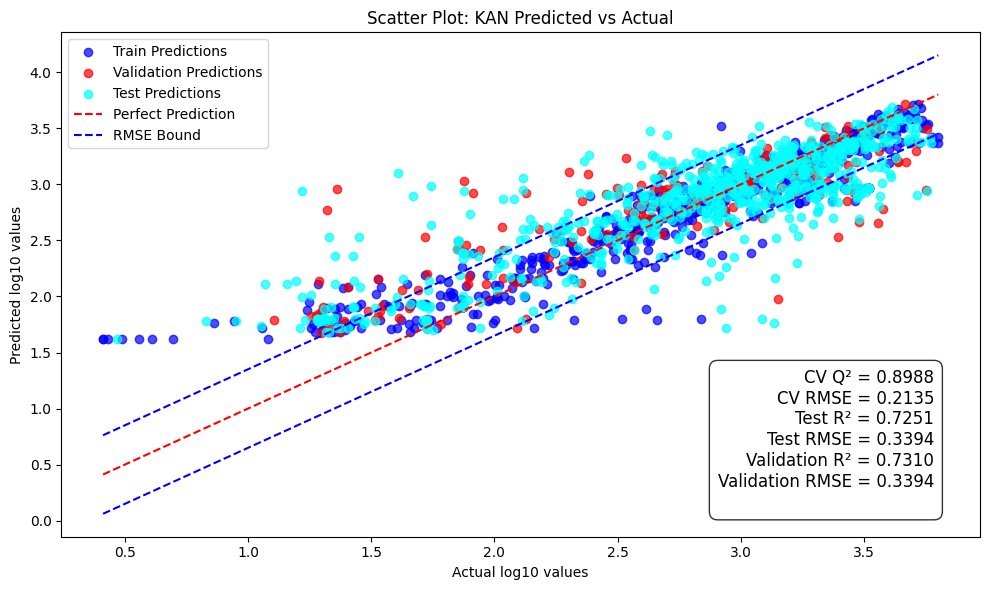

In [ ]:
# Function to train the model with early stopping
def train_model(model, train_data, val_data, optimizer, loss_fn, steps=500, patience=10):
    best_r2_val = -np.inf
    patience_counter = 0

    for step in range(steps):
        model.train()
        optimizer.zero_grad()
        output = model(train_data['train_input'])
        loss = loss_fn(output, train_data['train_label'])
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            model.eval()  # Switching model to evaluation mode

            # Predictions on training set
            with torch.no_grad():
                train_preds = model(train_data['train_input']).detach().cpu().numpy()
                train_r2 = r2_score(train_data['train_label'].cpu().numpy(), train_preds)

                # Predictions on validation set
                val_preds = model(val_data['val_input']).detach().cpu().numpy()
                val_r2 = r2_score(val_data['val_label'].cpu().numpy(), val_preds)

            # Printing metrics
            print(f"Step {step} | Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")

            # Early stopping
            if val_r2 > best_r2_val:
                best_r2_val = val_r2
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at step {step}.")
                break

    return model

# Storing metrics for cross-validation
r2_train_scores = []
r2_val_scores = []
r2_test_scores = []
rmse_train_scores = []
rmse_val_scores = []
rmse_test_scores = []

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1984)
for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled), 1):
    print(f"\n--- Fold {fold} ---")

    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Converting data into PyTorch tensors
    train_input = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    train_label = torch.tensor(y_train_fold.reshape(-1, 1), dtype=torch.float32).to(device)
    val_input = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    val_label = torch.tensor(y_val_fold.reshape(-1, 1), dtype=torch.float32).to(device)

    # Creating the model and optimizer
    model = create_kan_model(input_dim=X_train.shape[1], hidden_1=35, hidden_2=24, grid_size=95, spline_order=4)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Training the model
    model = train_model(model, {'train_input': train_input, 'train_label': train_label},
                        {'val_input': val_input, 'val_label': val_label},
                        optimizer, torch.nn.MSELoss(), steps=180, patience=180)

    # Model evaluation
    with torch.no_grad():
        train_preds = model(train_input).cpu().numpy()
        val_preds = model(val_input).cpu().numpy()
        test_preds = model(test_input).cpu().numpy()

    # Calculating metrics
    r2_train = r2_score(train_label.cpu().numpy(), train_preds)
    r2_val = r2_score(val_label.cpu().numpy(), val_preds)
    r2_test = r2_score(test_label.cpu().numpy(), test_preds)

    rmse_train = np.sqrt(mean_squared_error(train_label.cpu().numpy(), train_preds))
    rmse_val = np.sqrt(mean_squared_error(val_label.cpu().numpy(), val_preds))
    rmse_test = np.sqrt(mean_squared_error(test_label.cpu().numpy(), test_preds))

    # Storing results
    r2_train_scores.append(r2_train)
    r2_val_scores.append(r2_val)
    r2_test_scores.append(r2_test)
    rmse_train_scores.append(rmse_train)
    rmse_val_scores.append(rmse_val)
    rmse_test_scores.append(rmse_test)

    print(f"Fold {fold} Results: Train R²: {r2_train:.4f}, Val R²: {r2_val:.4f}, Test R²: {r2_test:.4f}")
    print(f"Fold {fold} Results: Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}, Test RMSE: {rmse_test:.4f}")

# Printing average values after all folds
print("\n--- Cross-Validation Results ---")
print(f"Avg Train R²: {np.mean(r2_train_scores):.4f} ± {np.std(r2_train_scores):.4f}")
print(f"Avg Val R²: {np.mean(r2_val_scores):.4f} ± {np.std(r2_val_scores):.4f}")
print(f"Avg Test R²: {np.mean(r2_test_scores):.4f} ± {np.std(r2_test_scores):.4f}")
print(f"Avg Train RMSE: {np.mean(rmse_train_scores):.4f} ± {np.std(rmse_train_scores):.4f}")
print(f"Avg Val RMSE: {np.mean(rmse_val_scores):.4f} ± {np.std(rmse_val_scores):.4f}")
print(f"Avg Test RMSE: {np.mean(rmse_test_scores):.4f} ± {np.std(rmse_test_scores):.4f}")

# Getting predictions for train, val, and test
train_preds = model(train_input).detach().cpu().numpy()
val_preds = model(val_input).detach().cpu().numpy()
test_preds = model(test_input).detach().cpu().numpy()

# Calculating metrics
test_r2 = r2_score(test_label.cpu().numpy(), test_preds)
final_test_rmse = np.sqrt(mean_squared_error(test_label.cpu().numpy(), test_preds))

val_r2 = r2_score(val_label.cpu().numpy(), val_preds)
val_rmse = np.sqrt(mean_squared_error(val_label.cpu().numpy(), val_preds))

cv_r2 = np.mean(r2_val_scores)  # Average R² from cross-validation
cv_rmse = np.mean(rmse_val_scores)  # Average RMSE from cross-validation

# Plotting
plt.figure(figsize=(10, 6))

# Setting minimum and maximum values for the axes
min_val = min(train_label.min(), val_label.min(), test_label.min()).cpu().numpy()
max_val = max(train_label.max(), val_label.max(), test_label.max()).cpu().numpy()

# Scatter plots
plt.scatter(train_label.cpu().numpy(), train_preds, alpha=0.7, color='blue', label='Train Predictions')
plt.scatter(val_label.cpu().numpy(), val_preds, alpha=0.7, color='red', label='Validation Predictions')
plt.scatter(test_label.cpu().numpy(), test_preds, alpha=0.7, color='cyan', label='Test Predictions')

# Ideal prediction line
ideal_line = np.linspace(min_val, max_val, 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Perfect Prediction')

# RMSE boundary lines
plt.plot(ideal_line, ideal_line + final_test_rmse, 'b--', label=f'RMSE Bound')
plt.plot(ideal_line, ideal_line - final_test_rmse, 'b--')

# Text with metrics
metrics_text = (
    f'CV Q² = {np.mean(r2_train_scores):.4f}\n'
    f'CV RMSE = {np.mean(rmse_train_scores):.4f}\n'
    f'Test R² = {np.mean(r2_test_scores):.4f}\n'
    f'Test RMSE = {np.mean(rmse_test_scores):.4f}\n'
    f'Validation R² = {np.mean(r2_val_scores):.4f}\n'
    f'Validation RMSE = {np.mean(rmse_test_scores):.4f}\n'
)

plt.text(0.95, 0.05, metrics_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='black'))

# Formatting the plot
plt.title('Scatter Plot: KAN Predicted vs Actual')
plt.xlabel('Actual log10 values')
plt.ylabel('Predicted log10 values')
plt.legend(loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

### SHAP

Feature names: ['space_group_core', 'space_group_shell', 'shape', 'Tc', 'temperature_k', 'h_range_max_koe', 'sat_em_g', 'coer_oe', 'mr (emu/g)', 'sphericity', 'max/min', 'area/volume', 'num_of_magn_ions', 'core_b', 'core_alpha', 'core_beta', 'core_gamma', 'shell_b', 'shell_alpha', 'shell_beta', 'shell_gamma', 'core_c/a', 'shell_c/a']
Shape of X_train_np: (820, 23)
Shape of X_test_np: (760, 23)


<ipython-input-31-b9208c05c8a1>:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names_renamed, show=False)


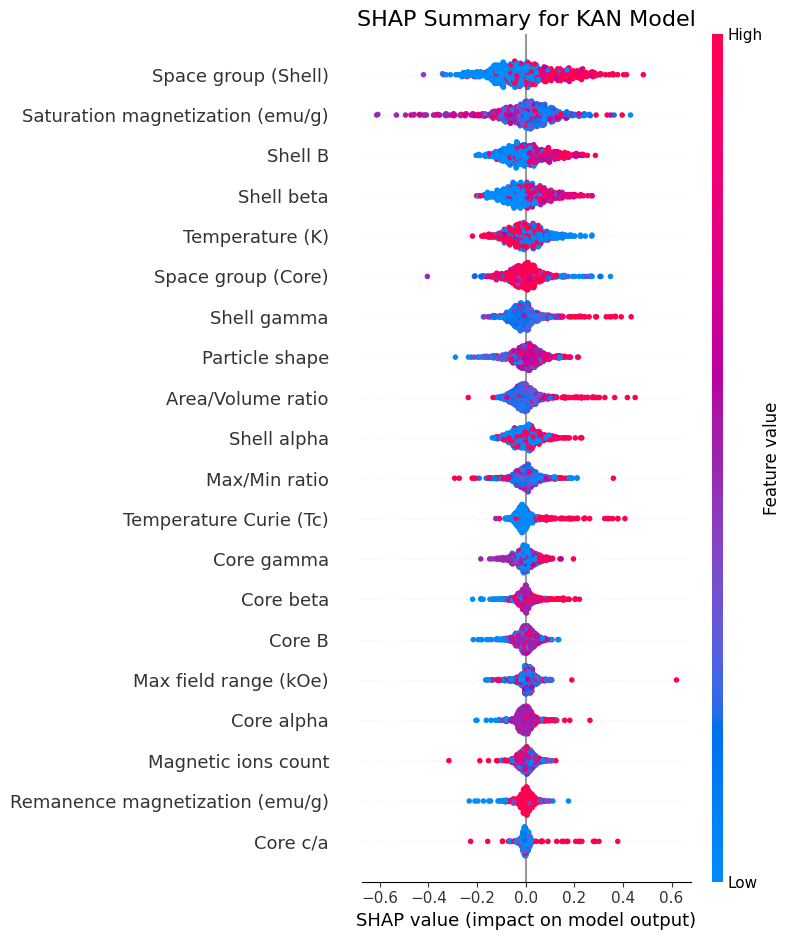

In [31]:
# Ensure that the input data is using only the features we defined in the rename_dict
feature_names = list(rename_dict.keys())  # Feature names to be renamed

# Select the columns from the data that correspond to the features in the rename_dict
X_train_np = X_train_np[:, :len(feature_names)]  # Ensure only selected features are used
X_test_np = X_test_np[:, :len(feature_names)]

# Ensure the feature names in the data match the number of selected features
if len(feature_names) != X_test_np.shape[1]:
    raise ValueError(f"The number of renamed features ({len(feature_names)}) does not match the number of features in the data ({X_test_np.shape[1]}).")

# Now the feature names should match
print(f"Feature names: {feature_names}")
print(f"Shape of X_train_np: {X_train_np.shape}")
print(f"Shape of X_test_np: {X_test_np.shape}")

# Convert data back to PyTorch tensors for SHAP
train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)

# Create the SHAP explainer
explainer = shap.GradientExplainer(model, train_tensor)  # Use your trained model here

# Compute SHAP values
shap_values = explainer.shap_values(test_tensor)

# Convert SHAP values to numpy array
if isinstance(shap_values, list):
    shap_values_np = np.array(shap_values[0])  # For regression tasks, use the first element
else:
    shap_values_np = np.array(shap_values)

# If SHAP values are multi-dimensional (samples, features, outputs), average across outputs
if shap_values_np.ndim == 3:
    shap_values_np = shap_values_np.mean(axis=2)

# Rename the feature names
feature_names_renamed = [rename_dict.get(f, f) for f in feature_names]

# Plotting the SHAP summary plot with renamed features
plt.figure(figsize=(10, 6))

# Create the SHAP summary plot
shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names_renamed, show=False)

# Add a title using Matplotlib
plt.title("SHAP Summary for KAN Model", fontsize=16)
plt.tight_layout()  # Ensure the plot is not cropped
plt.show()

## Saturation magnetization

Selected hyperparameter configurations:
```
models = {
    'efficient_KAN_1': {
        'hidden_1': 31, 'hidden_2': 6, 'grid_size': 73, 'spline_order': 4, 'step': 280
    },
    'efficient_KAN_2': {
        'hidden_1': 32, 'hidden_2': 12, 'grid_size': 82, 'spline_order': 5, 'step': 280
    },
    'efficient_KAN_3': {
        'hidden_1': 7, 'hidden_2': 33, 'grid_size': 84, 'spline_order': 5, 'step': 270
    },
    'efficient_KAN_4': {
        'hidden_1': 25, 'hidden_2': 31, 'grid_size': 70, 'spline_order': 4, 'step': 420
    },
    'efficient_KAN_5': {
        'hidden_1': 29, 'hidden_2': 11, 'grid_size': 67, 'spline_order': 5, 'step': 290
    },
    'efficient_KAN_6': {
        'hidden_1': 31, 'hidden_2': 29, 'grid_size': 32, 'spline_order': 2, 'step': 320
    }
}
```

In [ ]:
# Loading the data
df = pd.read_csv("/content/Megy_final.csv")
df = df.drop(columns=['x', 'y', 'z', 'link', 'orig_c1', 'orig_c2'])  # Dropping unnecessary columns

In [ ]:
rename_dict = {
    'space_group_core': 'Space group (Core)',
    'space_group_shell': 'Space group (Shell)',
    'Tc': 'Temperature Curie (Tc)',
    'shape': 'Particle shape',
    'temperature_k': 'Temperature (K)',
    'h_range_max_koe': 'Max field range (kOe)',
    'sat_em_g': 'Saturation magnetization (emu/g)',
    'coer_oe': 'Coercivity (Oe)',
    'mr (emu/g)': 'Remanence magnetization (emu/g)',
    'sphericity': 'Sphericity',
    'max/min': 'Max/Min ratio',
    'area/volume': 'Area/Volume ratio',
    'num_of_magn_ions': 'Magnetic ions count',
    'core_b': 'Core B',
    'core_alpha': 'Core alpha',
    'core_beta': 'Core beta',
    'core_gamma': 'Core gamma',
    'shell_b': 'Shell B',
    'shell_alpha': 'Shell alpha',
    'shell_beta': 'Shell beta',
    'shell_gamma': 'Shell gamma',
    'core_c/a': 'Core c/a',
    'shell_c/a': 'Shell c/a',
}

def smart_rename(col):
    return rename_dict.get(col, col.capitalize())

df.rename(columns=lambda col: smart_rename(col), inplace=True)

In [ ]:
# Data preprocessing
y = df['Saturation magnetization (emu/g)']
y = y[y > 0]  # Keep only positive values

# Applying smoothing to the target variable
y_smooth = gaussian_filter1d(y, sigma=2)
# Log transformation of the target variable
y_log = np.log10(y_smooth)

# Feature generation
X = df[df['Saturation magnetization (emu/g)'] > 0].drop(columns=['Saturation magnetization (emu/g)'])

In [ ]:
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.4, random_state=1984)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1984)

In [ ]:
# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Converting the data into PyTorch tensors
train_input = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32).to(device)
val_input = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
val_label = torch.tensor(y_val[:, None], dtype=torch.float32).to(device)
test_input = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
test_label = torch.tensor(y_test[:, None], dtype=torch.float32).to(device)

In [ ]:
# Function to create a model with parameters compatible with efficient-kan
def create_kan_model(input_dim, hidden_1, hidden_2, grid_size, spline_order, output_dim=1):
    layers_hidden = [input_dim, hidden_1, hidden_2, output_dim]
    model = KAN(layers_hidden=layers_hidden, grid_size=grid_size, spline_order=spline_order).to(device)
    return model

Using device: cuda

--- Fold 1 ---
Step 0 | Train R²: -15.2150 | Val R²: -18.7554
Step 10 | Train R²: -13.4852 | Val R²: -16.6302
Step 20 | Train R²: -11.5559 | Val R²: -14.2637
Step 30 | Train R²: -9.1672 | Val R²: -11.3299
Step 40 | Train R²: -6.2568 | Val R²: -7.7557
Step 50 | Train R²: -3.1111 | Val R²: -3.8830
Step 60 | Train R²: -0.6652 | Val R²: -0.8582
Step 70 | Train R²: 0.0300 | Val R²: 0.0116
Step 80 | Train R²: 0.1787 | Val R²: 0.1614
Step 90 | Train R²: 0.3605 | Val R²: 0.3311
Step 100 | Train R²: 0.4854 | Val R²: 0.4504
Step 110 | Train R²: 0.5930 | Val R²: 0.5510
Step 120 | Train R²: 0.6742 | Val R²: 0.6232
Step 130 | Train R²: 0.7384 | Val R²: 0.6735
Step 140 | Train R²: 0.7886 | Val R²: 0.7055
Step 150 | Train R²: 0.8295 | Val R²: 0.7257
Step 160 | Train R²: 0.8624 | Val R²: 0.7409
Step 170 | Train R²: 0.8874 | Val R²: 0.7517
Step 180 | Train R²: 0.9066 | Val R²: 0.7589
Fold 1 Results: Train R²: 0.9198, Val R²: 0.7624, Test R²: 0.7482
Fold 1 Results: Train RMSE: 0.1102

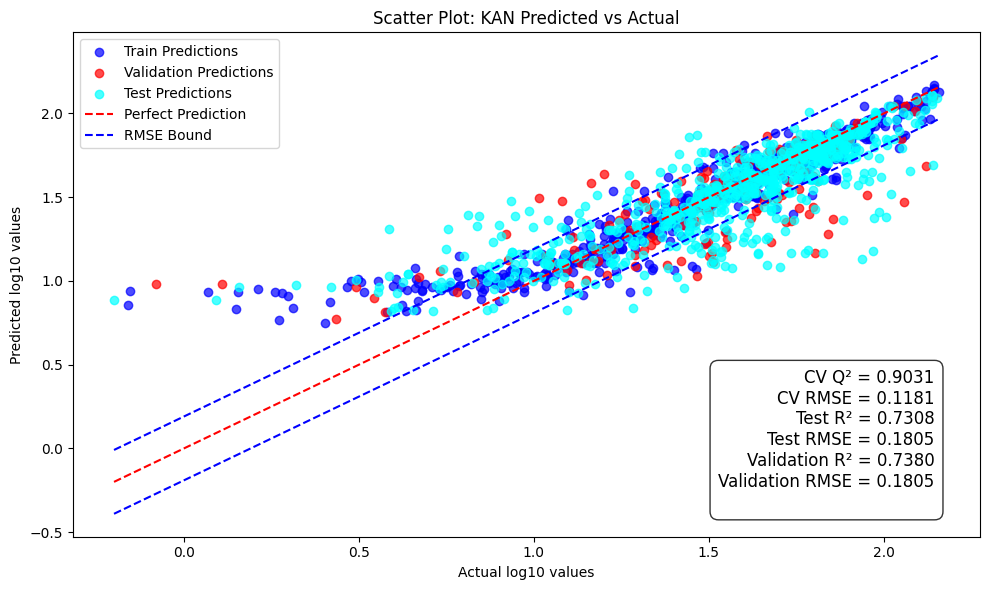

In [20]:
# Function to train the model with early stopping
def train_model(model, train_data, val_data, optimizer, loss_fn, steps=500, patience=10):
    best_r2_val = -np.inf
    patience_counter = 0

    for step in range(steps):
        model.train()
        optimizer.zero_grad()
        output = model(train_data['train_input'])
        loss = loss_fn(output, train_data['train_label'])
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            model.eval()  # Switching the model to evaluation mode

            # Predictions on the training set
            with torch.no_grad():
                train_preds = model(train_data['train_input']).detach().cpu().numpy()
                train_r2 = r2_score(train_data['train_label'].cpu().numpy(), train_preds)

                # Predictions on the validation set
                val_preds = model(val_data['val_input']).detach().cpu().numpy()
                val_r2 = r2_score(val_data['val_label'].cpu().numpy(), val_preds)

            # Print metrics
            print(f"Step {step} | Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")

            # Early stopping
            if val_r2 > best_r2_val:
                best_r2_val = val_r2
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at step {step}.")
                break

    return model

# Storing metrics for cross-validation
r2_train_scores = []
r2_val_scores = []
r2_test_scores = []
rmse_train_scores = []
rmse_val_scores = []
rmse_test_scores = []

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1984)
for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled), 1):
    print(f"\n--- Fold {fold} ---")

    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Converting the data into PyTorch tensors
    train_input = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    train_label = torch.tensor(y_train_fold.reshape(-1, 1), dtype=torch.float32).to(device)
    val_input = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    val_label = torch.tensor(y_val_fold.reshape(-1, 1), dtype=torch.float32).to(device)

    # Creating the model and optimizer
    model = create_kan_model(input_dim=X_train.shape[1], hidden_1=32, hidden_2=12, grid_size=82, spline_order=5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Training the model
    model = train_model(model, {'train_input': train_input, 'train_label': train_label},
                        {'val_input': val_input, 'val_label': val_label},
                        optimizer, torch.nn.MSELoss(), steps=190, patience=190)

    # Model evaluation
    with torch.no_grad():
        train_preds = model(train_input).cpu().numpy()
        val_preds = model(val_input).cpu().numpy()
        test_preds = model(test_input).cpu().numpy()

    # Computing metrics
    r2_train = r2_score(train_label.cpu().numpy(), train_preds)
    r2_val = r2_score(val_label.cpu().numpy(), val_preds)
    r2_test = r2_score(test_label.cpu().numpy(), test_preds)

    rmse_train = np.sqrt(mean_squared_error(train_label.cpu().numpy(), train_preds))
    rmse_val = np.sqrt(mean_squared_error(val_label.cpu().numpy(), val_preds))
    rmse_test = np.sqrt(mean_squared_error(test_label.cpu().numpy(), test_preds))

    # Storing results
    r2_train_scores.append(r2_train)
    r2_val_scores.append(r2_val)
    r2_test_scores.append(r2_test)
    rmse_train_scores.append(rmse_train)
    rmse_val_scores.append(rmse_val)
    rmse_test_scores.append(rmse_test)

    print(f"Fold {fold} Results: Train R²: {r2_train:.4f}, Val R²: {r2_val:.4f}, Test R²: {r2_test:.4f}")
    print(f"Fold {fold} Results: Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}, Test RMSE: {rmse_test:.4f}")

# Displaying the average results after all folds
print("\n--- Cross-Validation Results ---")
print(f"Avg Train R²: {np.mean(r2_train_scores):.4f} ± {np.std(r2_train_scores):.4f}")
print(f"Avg Val R²: {np.mean(r2_val_scores):.4f} ± {np.std(r2_val_scores):.4f}")
print(f"Avg Test R²: {np.mean(r2_test_scores):.4f} ± {np.std(r2_test_scores):.4f}")
print(f"Avg Train RMSE: {np.mean(rmse_train_scores):.4f} ± {np.std(rmse_train_scores):.4f}")
print(f"Avg Val RMSE: {np.mean(rmse_val_scores):.4f} ± {np.std(rmse_val_scores):.4f}")
print(f"Avg Test RMSE: {np.mean(rmse_test_scores):.4f} ± {np.std(rmse_test_scores):.4f}")

# Getting predictions for train, validation, and test
train_preds = model(train_input).detach().cpu().numpy()
val_preds = model(val_input).detach().cpu().numpy()
test_preds = model(test_input).detach().cpu().numpy()

# Computing metrics
test_r2 = r2_score(test_label.cpu().numpy(), test_preds)
final_test_rmse = np.sqrt(mean_squared_error(test_label.cpu().numpy(), test_preds))

val_r2 = r2_score(val_label.cpu().numpy(), val_preds)
val_rmse = np.sqrt(mean_squared_error(val_label.cpu().numpy(), val_preds))

cv_r2 = np.mean(r2_val_scores)  # Average R² from cross-validation
cv_rmse = np.mean(rmse_val_scores)  # Average RMSE from cross-validation

# Plotting
plt.figure(figsize=(10, 6))

# Minimum and maximum values for the axis
min_val = min(train_label.min(), val_label.min(), test_label.min()).cpu().numpy()
max_val = max(train_label.max(), val_label.max(), test_label.max()).cpu().numpy()

# Scatter plots
plt.scatter(train_label.cpu().numpy(), train_preds, alpha=0.7, color='blue', label='Train Predictions')
plt.scatter(val_label.cpu().numpy(), val_preds, alpha=0.7, color='red', label='Validation Predictions')
plt.scatter(test_label.cpu().numpy(), test_preds, alpha=0.7, color='cyan', label='Test Predictions')

# Ideal prediction line
ideal_line = np.linspace(min_val, max_val, 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Perfect Prediction')

# RMSE boundary lines
plt.plot(ideal_line, ideal_line + final_test_rmse, 'b--', label=f'RMSE Bound')
plt.plot(ideal_line, ideal_line - final_test_rmse, 'b--')

# Displaying metrics text
metrics_text = (
    f'CV Q² = {np.mean(r2_train_scores):.4f}\n'
    f'CV RMSE = {np.mean(rmse_train_scores):.4f}\n'
    f'Test R² = {np.mean(r2_test_scores):.4f}\n'
    f'Test RMSE = {np.mean(rmse_test_scores):.4f}\n'
    f'Validation R² = {np.mean(r2_val_scores):.4f}\n'
    f'Validation RMSE = {np.mean(rmse_test_scores):.4f}\n'
)

plt.text(0.95, 0.05, metrics_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='black'))

# Plot formatting
plt.title('Scatter Plot: KAN Predicted vs Actual')
plt.xlabel('Actual log10 values')
plt.ylabel('Predicted log10 values')
plt.legend(loc='upper left')
plt.tight_layout()

# Displaying the plot
plt.show()

### SHAP

Feature names: ['space_group_core', 'space_group_shell', 'Tc', 'temperature_k', 'h_range_max_koe', 'sat_em_g', 'coer_oe', 'mr (emu/g)', 'sphericity', 'max/min', 'area/volume', 'num_of_magn_ions', 'core_b', 'core_alpha', 'core_beta', 'core_gamma', 'shell_b', 'shell_alpha', 'shell_beta', 'shell_gamma', 'Aex', 'core_c/a', 'shell_c/a']
Shape of X_train_np: (820, 23)
Shape of X_test_np: (760, 23)


<ipython-input-21-b9208c05c8a1>:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names_renamed, show=False)


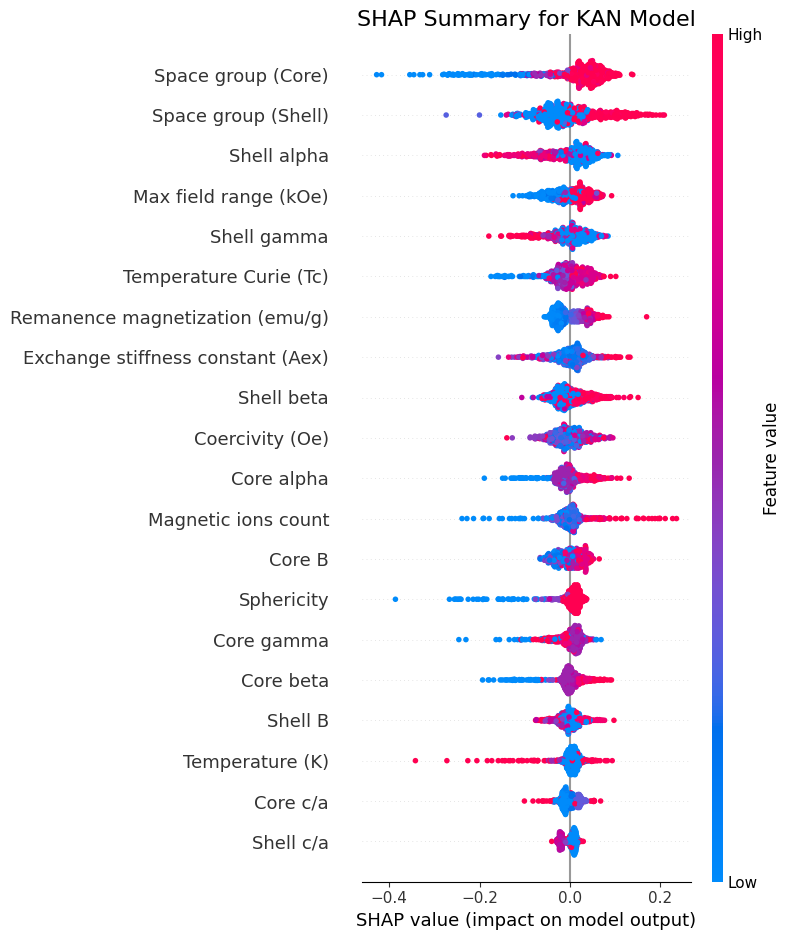

In [21]:
# Ensure that the input data is using only the features we defined in the rename_dict
feature_names = list(rename_dict.keys())  # Feature names to be renamed

# Select the columns from the data that correspond to the features in the rename_dict
X_train_np = X_train_np[:, :len(feature_names)]  # Ensure only selected features are used
X_test_np = X_test_np[:, :len(feature_names)]

# Ensure the feature names in the data match the number of selected features
if len(feature_names) != X_test_np.shape[1]:
    raise ValueError(f"The number of renamed features ({len(feature_names)}) does not match the number of features in the data ({X_test_np.shape[1]}).")

# Now the feature names should match
print(f"Feature names: {feature_names}")
print(f"Shape of X_train_np: {X_train_np.shape}")
print(f"Shape of X_test_np: {X_test_np.shape}")

# Convert data back to PyTorch tensors for SHAP
train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)

# Create the SHAP explainer
explainer = shap.GradientExplainer(model, train_tensor)  # Use your trained model here

# Compute SHAP values
shap_values = explainer.shap_values(test_tensor)

# Convert SHAP values to numpy array
if isinstance(shap_values, list):
    shap_values_np = np.array(shap_values[0])  # For regression tasks, use the first element
else:
    shap_values_np = np.array(shap_values)

# If SHAP values are multi-dimensional (samples, features, outputs), average across outputs
if shap_values_np.ndim == 3:
    shap_values_np = shap_values_np.mean(axis=2)

# Rename the feature names
feature_names_renamed = [rename_dict.get(f, f) for f in feature_names]

# Plotting the SHAP summary plot with renamed features
plt.figure(figsize=(10, 6))

# Create the SHAP summary plot
shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names_renamed, show=False)

# Add a title using Matplotlib
plt.title("SHAP Summary for KAN Model", fontsize=16)
plt.tight_layout()  # Ensure the plot is not cropped
plt.show()

## Remanence magnetization

Selected hyperparameter configurations:
```
models = {
    'efficient_KAN_1': {
        'hidden_1': 36, 'hidden_2': 27, 'grid_size': 67, 'spline_order': 2, 'step': 140
    },
    'efficient_KAN_2': {
        'hidden_1': 36, 'hidden_2': 27, 'grid_size': 67, 'spline_order': 2, 'step': 120
    },
    'efficient_KAN_3': {
        'hidden_1': 36, 'hidden_2': 27, 'grid_size': 67, 'spline_order': 2, 'step': 100
    },
    'efficient_KAN_4': {
        'hidden_1': 26, 'hidden_2': 20, 'grid_size': 33, 'spline_order': 2, 'step': 190
    },
    'efficient_KAN_5': {
        'hidden_1': 24, 'hidden_2': 24, 'grid_size': 32, 'spline_order': 2, 'step': 190
    },
    'efficient_KAN_6': {
        'hidden_1': 33, 'hidden_2': 16, 'grid_size': 32, 'spline_order': 5, 'step': 200
    }
}
```

In [ ]:
# Loading the data
df = pd.read_csv("/content/Megy_final.csv")
df = df.drop(columns=['x', 'y', 'z', 'link', 'orig_c1', 'orig_c2'])  # Removing unnecessary columns

In [ ]:
rename_dict = {
    'space_group_core': 'Space group (Core)',
    'space_group_shell': 'Space group (Shell)',
    'shape': 'Particle shape',
    'Tc': 'Temperature Curie (Tc)',
    'temperature_k': 'Temperature (K)',
    'h_range_max_koe': 'Max field range (kOe)',
    'sat_em_g': 'Saturation magnetization (emu/g)',
    'coer_oe': 'Coercivity (Oe)',
    'mr (emu/g)': 'Remanence magnetization (emu/g)',
    'sphericity': 'Sphericity',
    'max/min': 'Max/Min ratio',
    'area/volume': 'Area/Volume ratio',
    'num_of_magn_ions': 'Magnetic ions count',
    'core_b': 'Core B',
    'core_alpha': 'Core alpha',
    'core_beta': 'Core beta',
    'core_gamma': 'Core gamma',
    'shell_b': 'Shell B',
    'shell_alpha': 'Shell alpha',
    'shell_beta': 'Shell beta',
    'shell_gamma': 'Shell gamma',
    'core_c/a': 'Core c/a',
    'shell_c/a': 'Shell c/a',
}

def smart_rename(col):
    return rename_dict.get(col, col.capitalize())

df.rename(columns=lambda col: smart_rename(col), inplace=True)

In [ ]:
# Preprocessing
y = df['Remanence magnetization (emu/g)']
y = y[y > 0]  # Keep only positive values

# Apply smoothing to the target variable
y_smooth = gaussian_filter1d(y, sigma=2)
# Logarithmic transformation of the target variable
y_log = np.log10(y_smooth)

# Feature generation
X = df[df['Remanence magnetization (emu/g)'] > 0].drop(columns=['Remanence magnetization (emu/g)'])

In [ ]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.4, random_state=1984)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1984)

In [ ]:
# Data scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
train_input = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32).to(device)
val_input = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
val_label = torch.tensor(y_val[:, None], dtype=torch.float32).to(device)
test_input = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
test_label = torch.tensor(y_test[:, None], dtype=torch.float32).to(device)

In [ ]:
# Function to create the model with parameters compatible with efficient-kan
def create_kan_model(input_dim, hidden_1, hidden_2, grid_size, spline_order, output_dim=1):
    layers_hidden = [input_dim, hidden_1, hidden_2, output_dim]
    model = KAN(layers_hidden=layers_hidden, grid_size=grid_size, spline_order=spline_order).to(device)
    return model

Using device: cuda

--- Fold 1 ---
Step 0 | Train R²: -2.2353 | Val R²: -2.6906
Step 10 | Train R²: -1.6596 | Val R²: -1.9902
Step 20 | Train R²: -1.0261 | Val R²: -1.2244
Step 30 | Train R²: -0.3722 | Val R²: -0.4396
Step 40 | Train R²: 0.0481 | Val R²: 0.0522
Step 50 | Train R²: 0.1074 | Val R²: 0.0958
Step 60 | Train R²: 0.2315 | Val R²: 0.2106
Step 70 | Train R²: 0.3716 | Val R²: 0.3202
Step 80 | Train R²: 0.5014 | Val R²: 0.4146
Step 90 | Train R²: 0.6090 | Val R²: 0.4978
Step 100 | Train R²: 0.6926 | Val R²: 0.5538
Step 110 | Train R²: 0.7559 | Val R²: 0.5870
Step 120 | Train R²: 0.8052 | Val R²: 0.6099
Step 130 | Train R²: 0.8445 | Val R²: 0.6262
Step 140 | Train R²: 0.8752 | Val R²: 0.6345
Fold 1 Results: Train R²: 0.8858, Val R²: 0.6355, Test R²: 0.7029
Fold 1 Results: Train RMSE: 0.1999, Val RMSE: 0.3237, Test RMSE: 0.2738

--- Fold 2 ---
Step 0 | Train R²: -2.1660 | Val R²: -1.9672
Step 10 | Train R²: -1.4161 | Val R²: -1.3001
Step 20 | Train R²: -0.6735 | Val R²: -0.6342
St

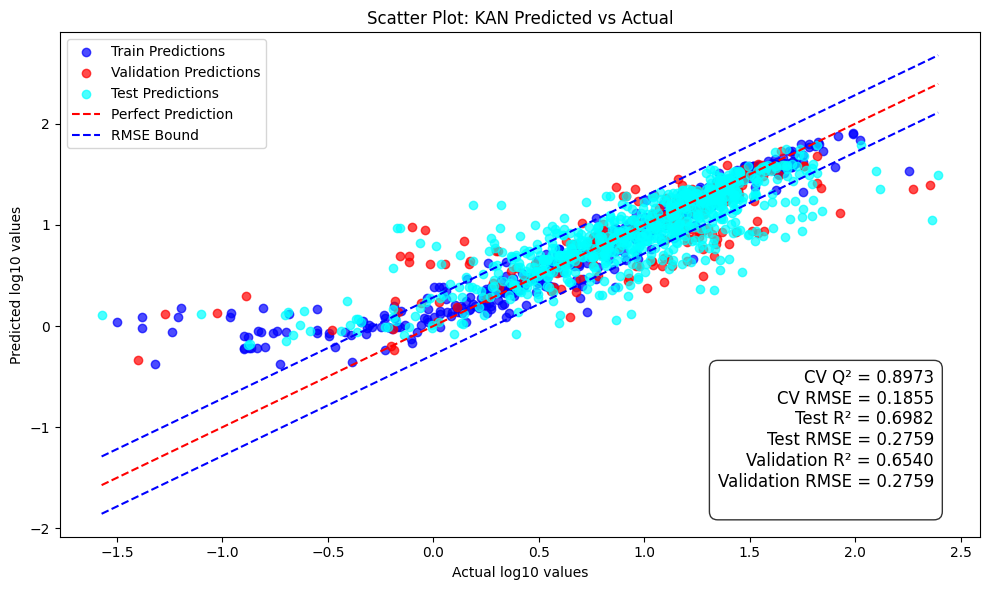

In [28]:
# Function for training the model with early stopping
def train_model(model, train_data, val_data, optimizer, loss_fn, steps=500, patience=10):
    best_r2_val = -np.inf
    patience_counter = 0

    for step in range(steps):
        model.train()
        optimizer.zero_grad()
        output = model(train_data['train_input'])
        loss = loss_fn(output, train_data['train_label'])
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            model.eval()  # Switching the model to evaluation mode

            # Predictions on training set
            with torch.no_grad():
                train_preds = model(train_data['train_input']).detach().cpu().numpy()
                train_r2 = r2_score(train_data['train_label'].cpu().numpy(), train_preds)

                # Predictions on validation set
                val_preds = model(val_data['val_input']).detach().cpu().numpy()
                val_r2 = r2_score(val_data['val_label'].cpu().numpy(), val_preds)

            # Printing metrics
            print(f"Step {step} | Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")

            # Early stopping
            if val_r2 > best_r2_val:
                best_r2_val = val_r2
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at step {step}.")
                break

    return model

# Storing metrics for cross-validation
r2_train_scores = []
r2_val_scores = []
r2_test_scores = []
rmse_train_scores = []
rmse_val_scores = []
rmse_test_scores = []

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1984)
for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled), 1):
    print(f"\n--- Fold {fold} ---")

    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Converting data to PyTorch tensors
    train_input = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    train_label = torch.tensor(y_train_fold.reshape(-1, 1), dtype=torch.float32).to(device)
    val_input = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    val_label = torch.tensor(y_val_fold.reshape(-1, 1), dtype=torch.float32).to(device)

    # Creating the model and optimizer
    model = create_kan_model(input_dim=X_train.shape[1], hidden_1=36, hidden_2=27,
                             grid_size=67, spline_order=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

    # Training the model
    model = train_model(model, {'train_input': train_input, 'train_label': train_label},
                        {'val_input': val_input, 'val_label': val_label},
                        optimizer, torch.nn.MSELoss(), steps=145, patience=145)

    # Model evaluation
    with torch.no_grad():
        train_preds = model(train_input).cpu().numpy()
        val_preds = model(val_input).cpu().numpy()
        test_preds = model(test_input).cpu().numpy()

    # Calculating metrics
    r2_train = r2_score(train_label.cpu().numpy(), train_preds)
    r2_val = r2_score(val_label.cpu().numpy(), val_preds)
    r2_test = r2_score(test_label.cpu().numpy(), test_preds)

    rmse_train = np.sqrt(mean_squared_error(train_label.cpu().numpy(), train_preds))
    rmse_val = np.sqrt(mean_squared_error(val_label.cpu().numpy(), val_preds))
    rmse_test = np.sqrt(mean_squared_error(test_label.cpu().numpy(), test_preds))

    # Saving results
    r2_train_scores.append(r2_train)
    r2_val_scores.append(r2_val)
    r2_test_scores.append(r2_test)
    rmse_train_scores.append(rmse_train)
    rmse_val_scores.append(rmse_val)
    rmse_test_scores.append(rmse_test)

    print(f"Fold {fold} Results: Train R²: {r2_train:.4f}, Val R²: {r2_val:.4f}, Test R²: {r2_test:.4f}")
    print(f"Fold {fold} Results: Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}, Test RMSE: {rmse_test:.4f}")

# Outputting average results after all folds
print("\n--- Cross-Validation Results ---")
print(f"Avg Train R²: {np.mean(r2_train_scores):.4f} ± {np.std(r2_train_scores):.4f}")
print(f"Avg Val R²: {np.mean(r2_val_scores):.4f} ± {np.std(r2_val_scores):.4f}")
print(f"Avg Test R²: {np.mean(r2_test_scores):.4f} ± {np.std(r2_test_scores):.4f}")
print(f"Avg Train RMSE: {np.mean(rmse_train_scores):.4f} ± {np.std(rmse_train_scores):.4f}")
print(f"Avg Val RMSE: {np.mean(rmse_val_scores):.4f} ± {np.std(rmse_val_scores):.4f}")
print(f"Avg Test RMSE: {np.mean(rmse_test_scores):.4f} ± {np.std(rmse_test_scores):.4f}")

# Getting predictions for train, validation, and test
train_preds = model(train_input).detach().cpu().numpy()
val_preds = model(val_input).detach().cpu().numpy()
test_preds = model(test_input).detach().cpu().numpy()

# Calculating metrics
test_r2 = r2_score(test_label.cpu().numpy(), test_preds)
final_test_rmse = np.sqrt(mean_squared_error(test_label.cpu().numpy(), test_preds))

val_r2 = r2_score(val_label.cpu().numpy(), val_preds)
val_rmse = np.sqrt(mean_squared_error(val_label.cpu().numpy(), val_preds))

cv_r2 = np.mean(r2_val_scores)  # Average R² from cross-validation
cv_rmse = np.mean(rmse_val_scores)  # Average RMSE from cross-validation

# Plotting
plt.figure(figsize=(10, 6))

# Min and max values for the axis
min_val = min(train_label.min(), val_label.min(), test_label.min()).cpu().numpy()
max_val = max(train_label.max(), val_label.max(), test_label.max()).cpu().numpy()

# Scatter plots
plt.scatter(train_label.cpu().numpy(), train_preds, alpha=0.7, color='blue', label='Train Predictions')
plt.scatter(val_label.cpu().numpy(), val_preds, alpha=0.7, color='red', label='Validation Predictions')
plt.scatter(test_label.cpu().numpy(), test_preds, alpha=0.7, color='cyan', label='Test Predictions')

# Ideal prediction line
ideal_line = np.linspace(min_val, max_val, 100)
plt.plot(ideal_line, ideal_line, 'r--', label='Perfect Prediction')

# RMSE boundary lines
plt.plot(ideal_line, ideal_line + final_test_rmse, 'b--', label=f'RMSE Bound')
plt.plot(ideal_line, ideal_line - final_test_rmse, 'b--')

# Metrics text
metrics_text = (
    f'CV Q² = {np.mean(r2_train_scores):.4f}\n'
    f'CV RMSE = {np.mean(rmse_train_scores):.4f}\n'
    f'Test R² = {np.mean(r2_test_scores):.4f}\n'
    f'Test RMSE = {np.mean(rmse_test_scores):.4f}\n'
    f'Validation R² = {np.mean(r2_val_scores):.4f}\n'
    f'Validation RMSE = {np.mean(rmse_test_scores):.4f}\n'
)

plt.text(0.95, 0.05, metrics_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='black'))

# Formatting the plot
plt.title('Scatter Plot: KAN Predicted vs Actual')
plt.xlabel('Actual log10 values')
plt.ylabel('Predicted log10 values')
plt.legend(loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

Strong overfitting of the model

## SHAP

Feature names: ['space_group_core', 'space_group_shell', 'shape', 'Tc', 'temperature_k', 'h_range_max_koe', 'sat_em_g', 'coer_oe', 'mr (emu/g)', 'sphericity', 'max/min', 'area/volume', 'num_of_magn_ions', 'core_b', 'core_alpha', 'core_beta', 'core_gamma', 'shell_b', 'shell_alpha', 'shell_beta', 'shell_gamma', 'core_c/a', 'shell_c/a']
Shape of X_train_np: (820, 23)
Shape of X_test_np: (760, 23)


<ipython-input-29-b9208c05c8a1>:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names_renamed, show=False)


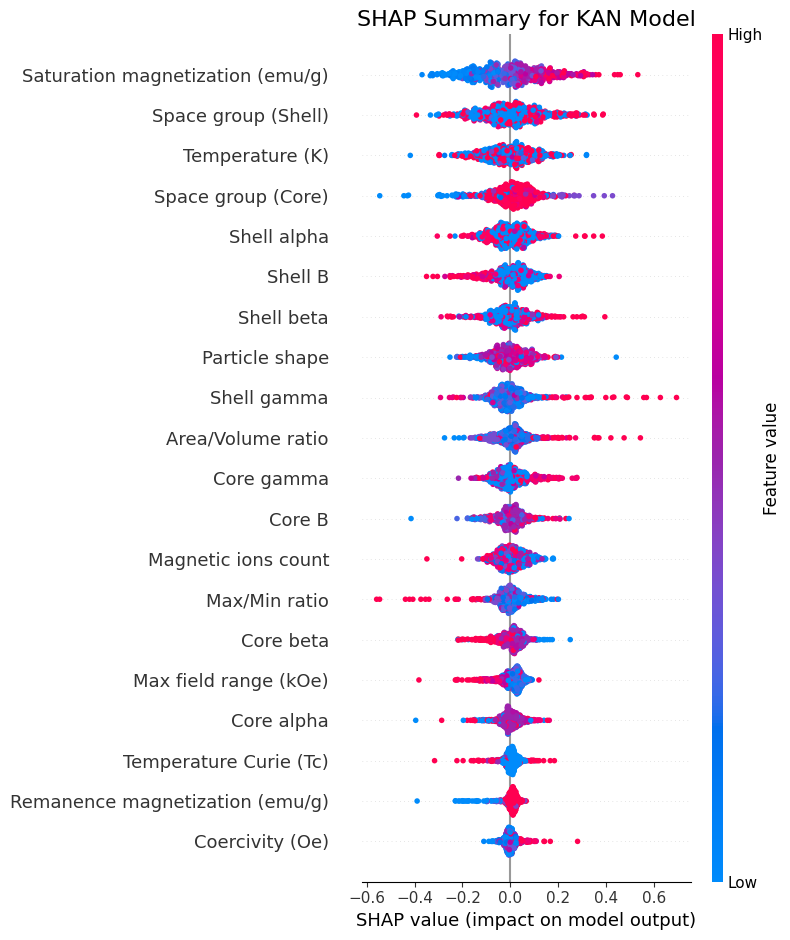

In [29]:
# Ensure that the input data is using only the features we defined in the rename_dict
feature_names = list(rename_dict.keys())  # Feature names to be renamed

# Select the columns from the data that correspond to the features in the rename_dict
X_train_np = X_train_np[:, :len(feature_names)]  # Ensure only selected features are used
X_test_np = X_test_np[:, :len(feature_names)]

# Ensure the feature names in the data match the number of selected features
if len(feature_names) != X_test_np.shape[1]:
    raise ValueError(f"The number of renamed features ({len(feature_names)}) does not match the number of features in the data ({X_test_np.shape[1]}).")

# Now the feature names should match
print(f"Feature names: {feature_names}")
print(f"Shape of X_train_np: {X_train_np.shape}")
print(f"Shape of X_test_np: {X_test_np.shape}")

# Convert data back to PyTorch tensors for SHAP
train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)

# Create the SHAP explainer
explainer = shap.GradientExplainer(model, train_tensor)  # Use your trained model here

# Compute SHAP values
shap_values = explainer.shap_values(test_tensor)

# Convert SHAP values to numpy array
if isinstance(shap_values, list):
    shap_values_np = np.array(shap_values[0])  # For regression tasks, use the first element
else:
    shap_values_np = np.array(shap_values)

# If SHAP values are multi-dimensional (samples, features, outputs), average across outputs
if shap_values_np.ndim == 3:
    shap_values_np = shap_values_np.mean(axis=2)

# Rename the feature names
feature_names_renamed = [rename_dict.get(f, f) for f in feature_names]

# Plotting the SHAP summary plot with renamed features
plt.figure(figsize=(10, 6))

# Create the SHAP summary plot
shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names_renamed, show=False)

# Add a title using Matplotlib
plt.title("SHAP Summary for KAN Model", fontsize=16)
plt.tight_layout()  # Ensure the plot is not cropped
plt.show()